In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression



In [ ]:
# ==========================================
# FEATURE ENGINEERING + PREP
# ==========================================
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

print("\n FEATURE ENGINEERING =====\n")

# --------------------------------------------------
# LOAD & CLEAN THE DATA
# --------------------------------------------------

df = pd.read_csv("healthcare_dataset_cleaned.csv")

# Drop irrelevant or ID-like columns
df = df.drop(["Name", "Doctor", "Room Number", "Hospital", "Medication", "Test Results"], axis=1)

# Convert date columns to datetime

# Convert dates again 
df["Date of Admission"] = pd.to_datetime(df["Date of Admission"], errors="coerce") 
df["Discharge Date"] = pd.to_datetime(df["Discharge Date"], errors="coerce") 
print("✅ df reset. Shape:", df.shape)
print(df.head(5))

print("✅ Dataset loaded and unnecessary columns removed.\n")

# --------------------------------------------------
# CREATE LENGTH OF STAY
# --------------------------------------------------

df["Length of Stay"] = (df["Discharge Date"] - df["Date of Admission"]).dt.days
print("✅ Length of Stay created successfully.\n")

# --------------------------------------------------
#  OUTLIER DETECTION (IQR METHOD)
# --------------------------------------------------

def detect_outliers_iqr(df, columns):
    outlier_summary = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower) | (df[col] > upper)].index
        outlier_summary[col] = list(outliers)
        print(f"{col}: {len(outliers)} outliers detected.")
    return outlier_summary

numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
outliers = detect_outliers_iqr(df, numeric_cols)

print("\n✅ Outlier detection completed.\n")

# --------------------------------------------------
# HANDLE CATEGORICAL ENCODING (SMART + SAFE)
# --------------------------------------------------

object_cols = df.select_dtypes(include="object").columns.tolist()
print("Object columns found:", object_cols)

# Label Encode small-cardinality columns (<=10 unique)
label_encode_cols = [col for col in object_cols if df[col].nunique() <= 10]

# Target Encode high-cardinality columns (>10 unique)
target_encode_cols = [col for col in object_cols if df[col].nunique() > 10]

# ---- Label Encoding ----
le = LabelEncoder()
for col in label_encode_cols:
    df[col] = le.fit_transform(df[col])
print("\nLabel Encoded:", label_encode_cols)

# ---- Target Encoding ----
for col in target_encode_cols:
    means = df.groupby(col)["Billing Amount"].mean()
    df[col] = df[col].map(means)
print("Target Encoded:", target_encode_cols)

print("\n✅ All categorical encoding completed successfully.\n")

# --------------------------------------------------
# PREPARE FINAL NUMERIC FEATURE MATRIX
# --------------------------------------------------

y = df["Billing Amount"]
X = df.drop(["Billing Amount"], axis=1)

# Convert DATETIME → numeric timestamps
datetime_cols = X.select_dtypes(include=["datetime64[ns]"]).columns
for col in datetime_cols:
    X[col] = X[col].astype("int64") // 10**9

# Ensure ALL features numeric
X = X.select_dtypes(include=[np.number])

print("✅ Final feature matrix prepared (numeric only).")
print(f"Final number of features: {X.shape[1]}\n")

# --------------------------------------------------
# FEATURE SELECTION (Random Forest Importance)
# --------------------------------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

feature_importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("✅ Random Forest Feature Importance Computed.\n")
print(feature_importances.head(20))



===== MODULE 2: FEATURE ENGINEERING =====

✅ df reset. Shape: (54966, 9)
   Age  Gender Blood Type Medical Condition Date of Admission  \
0   30    Male         B-            Cancer        2024-01-31   
1   62    Male         A+           Obesity        2019-08-20   
2   76  Female         A-           Obesity        2022-09-22   
3   28  Female         O+          Diabetes        2020-11-18   
4   43  Female        AB+            Cancer        2022-09-19   

  Insurance Provider  Billing Amount Admission Type Discharge Date  
0         Blue Cross    18856.281306         Urgent     2024-02-02  
1           Medicare    33643.327287      Emergency     2019-08-26  
2              Aetna    27955.096079      Emergency     2022-10-07  
3           Medicare    37909.782410       Elective     2020-12-18  
4              Aetna    14238.317814         Urgent     2022-10-09  
✅ Dataset loaded and unnecessary columns removed.

✅ Length of Stay created successfully.

Age: 0 outliers detected.
Bill

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression


✅ Train/Test Split Complete: (43972, 9) (10994, 9)

===== Random Forest RESULTS =====
MAE  : 11747.49
MSE  : 190877281.70
RMSE : 13815.83
R²   : 0.0628

===== Linear Regression RESULTS =====
MAE  : 12369.31
MSE  : 203691961.18
RMSE : 14272.07
R²   : -0.0001

✅ Random Forest 5-Fold CV R²: 0.05849077678664647

✅ Best RF Params: {'n_estimators': 200, 'min_samples_split': 5, 'max_depth': None}

===== BEST Random Forest RESULTS =====
MAE  : 11829.98
MSE  : 192180912.78
RMSE : 13862.93
R²   : 0.0564

===== MODEL COMPARISON =====
                Model        R²          RMSE
0   Linear Regression -0.000114  14272.069268
1       Random Forest  0.062805  13815.834455
2  Best Random Forest  0.056404  13862.933051


C:\Users\shetg\AppData\Local\Temp\ipykernel_14568\372659167.py:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=model_scores, x="Model", y="R²", palette="viridis")


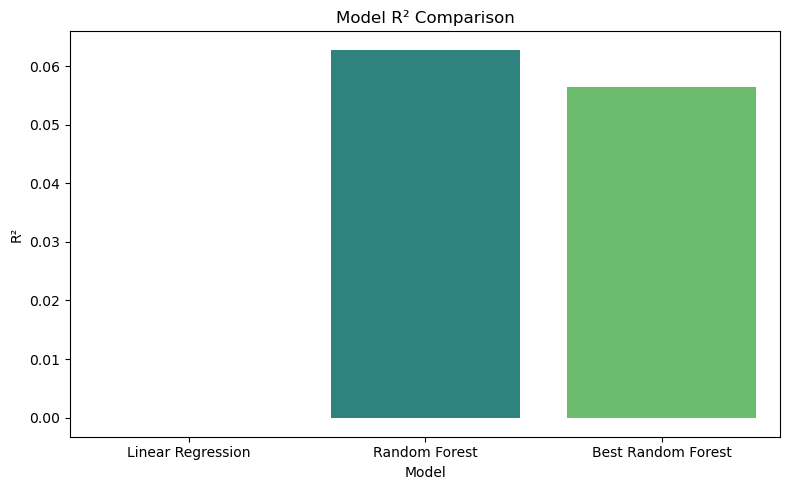

C:\Users\shetg\AppData\Local\Temp\ipykernel_14568\372659167.py:120: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rf_imp.head(15), x="Importance", y="Feature", palette="coolwarm")


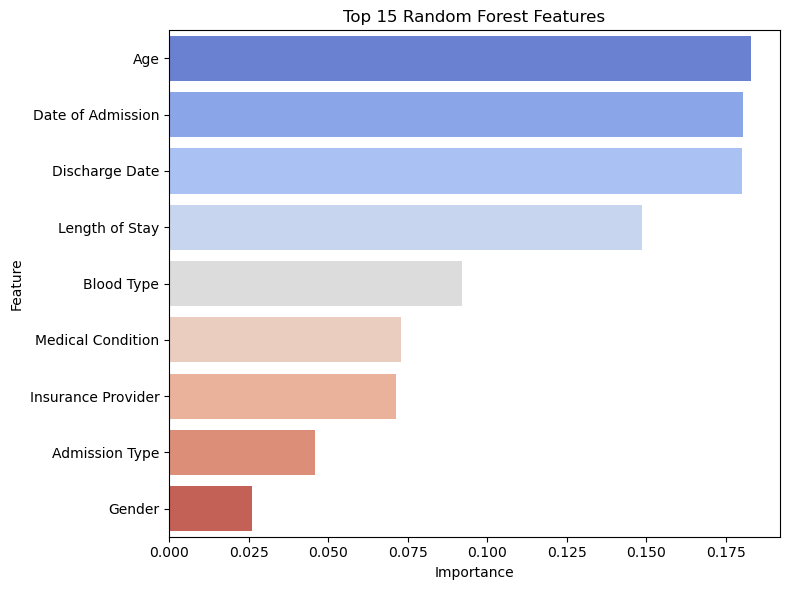

In [ ]:
# ================================================================
# FULL ADVANCED MACHINE LEARNING PIPELINE (RF + LR)
# ================================================================

# ------------------------------------------------------------
# 1. TRAIN–TEST SPLIT
# ------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("✅ Train/Test Split Complete:", X_train.shape, X_test.shape)

# ------------------------------------------------------------
# METRICS FUNCTION
# ------------------------------------------------------------
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"\n===== {name} RESULTS =====")
    print(f"MAE  : {mae:.2f}")
    print(f"MSE  : {mse:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"R²   : {r2:.4f}")
    return [mae, mse, rmse, r2]


# ------------------------------------------------------------
# 2. BASE MODELS (TRAIN + EVALUATE)
# ------------------------------------------------------------

# Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_metrics = evaluate_model("Random Forest", y_test, rf_pred)

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_metrics = evaluate_model("Linear Regression", y_test, lr_pred)


# ------------------------------------------------------------
# 3. CROSS-VALIDATION (K-Fold)
# ------------------------------------------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rf_cv_scores = []
for train_idx, test_idx in kf.split(X):
    rf.fit(X.iloc[train_idx], y.iloc[train_idx])
    preds = rf.predict(X.iloc[test_idx])
    rf_cv_scores.append(r2_score(y.iloc[test_idx], preds))

print("\n✅ Random Forest 5-Fold CV R²:", np.mean(rf_cv_scores))


# ------------------------------------------------------------
# 4. HYPERPARAMETER TUNING (RandomSearch for RF)
# ------------------------------------------------------------

rf_params = {
    "n_estimators": [100, 200, 300],
    "max_depth": [5, 10, 20, None],
    "min_samples_split": [2, 5, 10]
}

rf_random = RandomizedSearchCV(
    rf, rf_params,
    n_iter=10,
    scoring="r2",
    cv=3,
    random_state=42,
    n_jobs=-1
)

rf_random.fit(X_train, y_train)

print("\n✅ Best RF Params:", rf_random.best_params_)

best_rf = rf_random.best_estimator_
best_rf_pred = best_rf.predict(X_test)
best_rf_metrics = evaluate_model("BEST Random Forest", y_test, best_rf_pred)


# ------------------------------------------------------------
# 5. MODEL COMPARISON DASHBOARD
# ------------------------------------------------------------

model_scores = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest", "Best Random Forest"],
    "R²": [lr_metrics[3], rf_metrics[3], r2_score(y_test, best_rf_pred)],
    "RMSE": [lr_metrics[2], rf_metrics[2],
             np.sqrt(mean_squared_error(y_test, best_rf_pred))]
})

print("\n===== MODEL COMPARISON =====")
print(model_scores)

plt.figure(figsize=(8, 5))
sns.barplot(data=model_scores, x="Model", y="R²", palette="viridis")
plt.title("Model R² Comparison")
plt.tight_layout()
plt.show()


# ------------------------------------------------------------
# 6. FEATURE IMPORTANCE PLOTS (Random Forest)
# ------------------------------------------------------------

rf_imp = pd.DataFrame({
    "Feature": X.columns,
    "Importance": best_rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(data=rf_imp.head(15), x="Importance", y="Feature", palette="coolwarm")
plt.title("Top 15 Random Forest Features")
plt.tight_layout()
plt.show()
